In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers, 404 bytes cmem[0], 8 bytes cmem[2]
ptxas info    : Compile time = 8.640 ms
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info   

<Axes: >

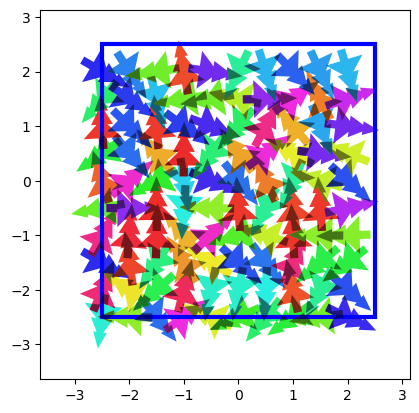

In [2]:
import pack_vis_sol
N_individuals = 200000
xy = cp.meshgrid(cp.arange(10), cp.arange(10))
x = (xy[0].ravel()-5)/2
y = (xy[1].ravel()-5)/2
t = cp.random.default_rng(seed=42).uniform(0, 2*np.pi, size=x.shape[0])
xyt = cp.stack([x, y, t], axis=1)
xyt.shape

sol = kgs.SolutionCollectionSquare()
sol.xyt = cp.tile(xyt, (N_individuals, 1, 1))
sol.xyt[:, :, 2] += cp.random.default_rng(seed=43).uniform(0, 2*np.pi, size=(N_individuals, sol.N_trees))
sol.h = cp.tile(cp.array([[5.,0.,0.]], dtype=cp.float32), (N_individuals, 1))
sol.xyt = sol.xyt.astype(cp.float32)
sol.h = sol.h.astype(cp.float32)
sol.check_constraints()

pack_vis_sol.pack_vis_sol(sol)

In [3]:
%%time
cost1 = pack_cost.CollisionCostSeparation().compute_cost_allocate(sol)[0].get()

CPU times: user 858 ms, sys: 0 ns, total: 858 ms
Wall time: 857 ms


In [ ]:
import pack_cuda_lut
importlib.reload(pack_cuda_lut)
pack_cuda_lut.USE_TEXTURE = False

# Force reinitialization (picks up code changes including sincosf/floorf fixes)
pack_cuda_lut._initialized = False

# LUT grid dimensions
N_X = 200
N_Y = 200
N_THETA = 200
MAX_R = kgs.tree_max_radius

# Create grid arrays
pack_cuda_lut.LUT_X = np.linspace(-2*MAX_R, 2*MAX_R, N_X)
pack_cuda_lut.LUT_Y = np.linspace(-2*MAX_R, 2*MAX_R, N_Y)
pack_cuda_lut.LUT_theta = np.linspace(-np.pi, np.pi, N_THETA)

# Create meshgrid for all (dx, dy, dtheta) combinations
dx_grid, dy_grid, dt_grid = cp.meshgrid(
    cp.asarray(pack_cuda_lut.LUT_X, dtype=cp.float32),
    cp.asarray(pack_cuda_lut.LUT_Y, dtype=cp.float32),
    cp.asarray(pack_cuda_lut.LUT_theta, dtype=cp.float32),
    indexing='ij'
)

# Flatten to get all combinations
N_individuals = N_X * N_Y * N_THETA
dx_flat = dx_grid.ravel()
dy_flat = dy_grid.ravel()
dt_flat = dt_grid.ravel()

print(f"Building LUT with {N_individuals} grid points ({N_X} x {N_Y} x {N_THETA})")

# Create solution with 2 trees per individual:
# Tree 0: at origin (0, 0, 0)
# Tree 1: at (dx, dy, dtheta)
xyt_lut = cp.zeros((N_individuals, 2, 3), dtype=cp.float32)
xyt_lut[:, 1, 0] = dx_flat  # x of tree 1
xyt_lut[:, 1, 1] = dy_flat  # y of tree 1
xyt_lut[:, 1, 2] = dt_flat  # theta of tree 1

sol_lut = kgs.SolutionCollectionSquare()
sol_lut.xyt = xyt_lut
sol_lut.h = cp.tile(cp.array([[10., 0., 0.]], dtype=cp.float32), (N_individuals, 1))  # large boundary, no clipping
sol_lut.check_constraints()

print(f"Solution shape: xyt={sol_lut.xyt.shape}, h={sol_lut.h.shape}")

# Compute costs using existing cost function
cost_fn = pack_cost.CollisionCostSeparation()
lut_costs, _, _ = cost_fn.compute_cost_allocate(sol_lut)
lut_costs_np = lut_costs.get()

print(f"Cost range: [{lut_costs_np.min():.6f}, {lut_costs_np.max():.6f}]")

# Reshape to LUT grid shape (N_X, N_Y, N_THETA)
pack_cuda_lut.LUT_vals = lut_costs_np.reshape(N_X, N_Y, N_THETA).astype(np.float32)
print(f"LUT_vals shape: {pack_cuda_lut.LUT_vals.shape}")

pack_cuda_lut._ensure_initialized()

Building LUT with 8000000 grid points (200 x 200 x 200)
Solution shape: xyt=(8000000, 2, 3), h=(8000000, 3)
Cost range: [0.000000, 0.298711]
LUT_vals shape: (200, 200, 200)
init CUDA LUT (USE_TEXTURE=False)
Detected GPU compute capability: 89 (arch=sm_89)
Compiling: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -lineinfo -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_lut_saved.cu -o /mnt/d//packing/temp/pack_cuda_lut.cubin
/mnt/d//packing/temp/pack_cuda_lut_saved.cu:5: warning: "M_PI" redefined
    5 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/13/cmath:47,
                 from /usr/include/c++/13/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/math_functions.h:4577,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/common_functions.h:303,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/includ

[ 0.00126696  0.00072289  0.00112534 -0.0071106  -0.00309515 -0.0029273
  0.00013494  0.00238991 -0.00057364  0.0025382 ]


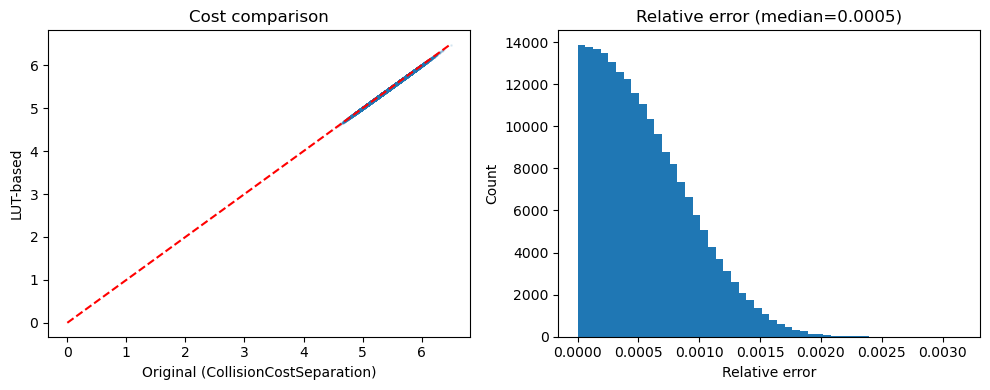

In [5]:
# Now test LUT-based computation against original
cost2_cp = cp.empty(cost1.shape, dtype=cp.float32)
pack_cuda_lut.overlap_multi_ensemble(sol.xyt, sol.xyt, cost2_cp)
cost2 = cost2_cp.get()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(cost1, cost2, alpha=0.1, s=1)
plt.xlabel('Original (CollisionCostSeparation)')
plt.ylabel('LUT-based')
plt.title('Cost comparison')
plt.plot([0, cost1.max()], [0, cost1.max()], 'r--', label='y=x')

plt.subplot(1, 2, 2)
rel_error = np.abs(cost2 - cost1) / (cost1 + 1e-10)
plt.hist(rel_error[cost1 > 0.01], bins=50)
plt.xlabel('Relative error')
plt.ylabel('Count')
plt.title(f'Relative error (median={np.median(rel_error[cost1 > 0.01]):.4f})')
plt.tight_layout()

print((cost2-cost1)[:10])

In [6]:
# Timing comparison
import time

# Warm up
for _ in range(3):
    cost_fn.compute_cost_allocate(sol, evaluate_gradient=False)
    pack_cuda_lut.overlap_multi_ensemble(sol.xyt, sol.xyt, cost2_cp)
    cp.cuda.Device().synchronize()

# Time original
n_runs = 10
cp.cuda.Device().synchronize()
t0 = time.perf_counter()
for _ in range(n_runs):
    cost_fn.compute_cost_allocate(sol)
    cp.cuda.Device().synchronize()
t_orig = (time.perf_counter() - t0) / n_runs

# Time LUT
cp.cuda.Device().synchronize()
t0 = time.perf_counter()
for _ in range(n_runs):
    pack_cuda_lut.overlap_multi_ensemble(sol.xyt, sol.xyt, cost2_cp)
    cp.cuda.Device().synchronize()
t_lut = (time.perf_counter() - t0) / n_runs

print(f"Original (CollisionCostSeparation): {t_orig*1000:.2f} ms")
print(f"LUT-based: {t_lut*1000:.2f} ms")
print(f"Speedup: {t_orig/t_lut:.1f}x")

Original (CollisionCostSeparation): 840.14 ms
LUT-based: 32.46 ms
Speedup: 25.9x


In [7]:
# CUDA profiling with nsight
# Run: ncu --set full python -c "..." or use CuPy's built-in profiler

# Quick profiling with CuPy
from cupyx.profiler import benchmark

# Profile LUT kernel
print("=== LUT Kernel Profiling ===")
result = benchmark(
    lambda: pack_cuda_lut.overlap_multi_ensemble(sol.xyt, sol.xyt, cost2_cp),
    n_repeat=20,
    n_warmup=5
)
print(result)

print("\n=== Original Cost Function Profiling ===")
result2 = benchmark(
    lambda: cost_fn.compute_cost_allocate(sol, evaluate_gradient=False),
    n_repeat=20,
    n_warmup=5
)
print(result2)

=== LUT Kernel Profiling ===
<lambda>            :    CPU:   177.236 us   +/- 41.734 (min:   115.679 / max:   302.504) us     GPU-0: 32958.759 us   +/- 658.583 (min: 32520.191 / max: 34644.993) us

=== Original Cost Function Profiling ===
<lambda>            :    CPU:   321.771 us   +/- 28.810 (min:   280.746 / max:   366.199) us     GPU-0: 829608.746 us   +/- 7249.609 (min: 823456.421 / max: 848131.226) us
